<a href="https://colab.research.google.com/github/AhmedAlshoki/MusicRecommendaition/blob/main/MusicRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('musicrecommendationjovian')
jovian.set_colab_id('12xYz5CaNsd2fX0FAda48kvvdLod2mF0L')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import io
from google.colab import files
import gc
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from datetime import datetime

**Load The Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/MusicRecommendation/train.csv')

In [ ]:
test_set = pd.read_csv('/content/drive/MyDrive/MusicRecommendation/test.csv')

In [ ]:
songs_data =pd.read_csv('/content/drive/MyDrive/MusicRecommendation/songs.csv')

In [ ]:
members_data = pd.read_csv('/content/drive/MyDrive/MusicRecommendation/members.csv')

In [ ]:
#uploaded = files.upload()
#members_data = pd.read_csv(io.BytesIO(uploaded['members.csv']),encoding='ISO-8859-1')

In [ ]:
#uploaded = files.upload()
#songs_data = pd.read_csv(io.BytesIO(uploaded['songs.csv']),encoding='ISO-8859-1')

Preparing members data before merging with train and test sets 

In [ ]:
members_data['bd'] =members_data['bd'].astype(int) +42 #shift all ages by 42 (the minimum negative number in members.csv)

In [ ]:
data_mean, data_std = np.mean(members_data['bd']), np.std(members_data['bd'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

In [ ]:
def deal_with_bd_outliers():
   threshold=3
   count = 0
   mean_1 = np.mean(members_data['bd'])
   std_1 =np.std(members_data['bd'])  
   members_data.drop(['gender'],axis=1, inplace=True)
   for y in members_data['bd']:       
        z_score= abs(y - mean_1)/std_1 
        if z_score > threshold:
          y_ = abs(int(mean_1 + (np.sign(z_score)*3*std_1)))  
          members_data['bd'][count] = abs(int(mean_1 + (np.sign(z_score)*3*std_1))) 
          #print(y," ",y_," ",count)
        count +=1   
deal_with_bd_outliers()        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
members_data.describe()

Preparing songs data before merging with train and test sets

In [ ]:
def replace_drop_encode_songs(songs_data):
  #fill Nan values in genre_ids and language ; artist_name has no Nan value
  songs_data['genre_ids']=songs_data['genre_ids'].fillna('0')
  songs_data['language']=songs_data['language'].fillna(0)
  #drop composer has  45% Nan values and lyricist has over 80% Nan values
  songs_data.drop(['composer','lyricist'],axis=1, inplace=True)
  codec , unique = pd.factorize(songs_data['artist_name']) 
  songs_data['artist_name'] = pd.Series(codec)
  return songs_data
songs_data = replace_drop_encode_songs(songs_data)

Saving genres ids' columns values to avoid any missing values on train and test sets

In [ ]:
df_dum = songs_data['genre_ids'].str.get_dummies()
df_dum
columns = df_dum.columns.values
columns = list(columns)
del df_dum
gc.collect()

17

**Merging memebers and songs data within train and test data frames then concatenate train and test in single data frame**

In [ ]:
train_set = pd.merge(train_set, songs_data, on='song_id', how='outer')
train_set = pd.merge(train_set, members_data, on='msno', how='inner')
test_set = pd.merge(test_set, songs_data, on='song_id', how='outer')
test_set = pd.merge(test_set, members_data, on='msno', how='inner')
del songs_data
del members_data

In [ ]:
target = train_set.pop('target')
target_length = len(target)

In [ ]:
train_set = pd.concat([train_set,test_set])
del test_set

Factoise the categoriecal features on the concatenated data frame 

In [ ]:
def encode_single_categorical_data():
  global train_set
  codec , unique = pd.factorize(train_set['source_system_tab'],na_sentinel=0)
  train_set['source_system_tab']= codec
  codec , unique = pd.factorize(train_set['source_screen_name'],na_sentinel=0)
  train_set['source_screen_name']= codec
  codec , unique = pd.factorize(train_set['source_type'],na_sentinel=0)
  train_set['source_type']= codec
encode_single_categorical_data()

In [ ]:
def split_and_join(the_date):
    n = [4,2,2]
    return'/'.join([the_date[sum(n[:i]):sum(n[:i+1])] for i in range(len(n))]) 
def convert_to_date(date_time_str):
    date_time_obj = datetime.strptime(date_time_str, '%Y/%m/%d') 
    return date_time_obj   

In [ ]:
def deal_with_dates():
  global train_set
  train_set =train_set.astype({'registration_init_time':str
                      ,'expiration_date':str })
  train_set['registration_init_time'] =train_set['registration_init_time'].apply(split_and_join)
  train_set['expiration_date'] =train_set['expiration_date'].apply(split_and_join)
  train_set['registration_init_time'] =train_set['registration_init_time'].apply(convert_to_date)
  train_set['expiration_date'] =train_set['expiration_date'].apply(convert_to_date)
deal_with_dates()  

Normlize the data

In [ ]:
StandardScaler_ = StandardScaler(with_mean=False)
train_set_ = StandardScaler_.fit_transform(X=train_set[train_set.columns.difference(['msno', 'song_id','id','genre_ids','registration_init_time','expiration_date'])])  
train_set[train_set.columns.difference(['msno', 'song_id','id','genre_ids','registration_init_time','expiration_date'])] = train_set_

**Then seprate them right after dealing with categorical data to avoid RAM cost in gener_ids feature**

In [ ]:
test_set = train_set[:][target_length:]
train_set = train_set[:][:target_length]
train_set.insert(train_set.shape[1], "target", target)

**Genres_ids within train_set**

In [ ]:
def encode_feature(data):
  data_dummies=data['genre_ids'].str.get_dummies(sep='|')
  data.drop(['genre_ids'],axis=1, inplace=True)
  data['registration_init_time_Year'] = pd.DatetimeIndex(data['registration_init_time']).year
  data['registration_init_time_Month'] = pd.DatetimeIndex(data['registration_init_time']).month
  data['registration_init_time_Day'] = pd.DatetimeIndex(data['registration_init_time']).day
  data.drop(['registration_init_time'],axis=1,inplace=True)
  data['expiration_date_Year'] = pd.DatetimeIndex(data['expiration_date']).year
  data['expiration_date_Month'] = pd.DatetimeIndex(data['expiration_date']).month
  data['expiration_date_Day'] = pd.DatetimeIndex(data['expiration_date']).day
  data.drop(['expiration_date'],axis=1,inplace=True)
  data = pd.concat([data,data_dummies],axis=1)
  del data_dummies
  gc.collect()
  return data
train_set =encode_feature(train_set)

Next four cills to add the missing genres into the data frame

In [ ]:
train_cols = train_set.columns.values
train_cols = list(train_cols)

In [ ]:
diffrence_col_train = []
for column in columns:
    if column in train_cols:
      continue
    else :
      diffrence_col_train.append(column)

In [ ]:
train_set[diffrence_col_train] = 0

In [ ]:
train_set = train_set.reindex(sorted(train_set.columns), axis=1)

Save training set to avoid RAM limit usage the delete it

In [ ]:
path = '/content/drive/MyDrive/MusicRecommendation/train_prepeared.csv'
with open(path, 'w', encoding = 'ISO-8859-1') as f:
  train_set.to_csv(f)

In [ ]:
train_set.info()
del train_set
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Columns: 211 entries, 0 to target
dtypes: float64(11), int64(198), object(2)
memory usage: 1.7+ GB


0

In [ ]:
jovian.commit()

Then repeat the same process with test set

In [ ]:
test_set =encode_feature(test_set)

In [ ]:
test_set

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,artist_name,language,city,bd,...,94,940,947,95,958,965,972,979,986,993
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,3.069138,0.994436,1.902367,3.236459,0.269533,0.139605,0.150457,2.689352,...,0,0,0,0,0,0,0,0,0,0
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,3.069138,0.994436,1.902367,4.627618,0.000480,0.139605,0.150457,2.689352,...,0,0,0,0,0,0,0,0,0,0
2,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,A4Xu2KK/i4wlarqf8SOQ61S/XTIDEaNtKSKKHWGca4w=,3.069138,0.994436,1.902367,4.562739,0.109048,0.139605,0.150457,2.689352,...,0,0,0,0,0,0,0,0,0,0
3,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,YJKHI4Asj1oM5vJftbISis2QYliVSExtWiWnwb7TOgo=,3.069138,0.994436,1.902367,2.977447,0.111791,2.419827,0.150457,2.689352,...,0,0,0,0,0,0,0,0,0,0
4,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,pcxJbwDNuVwQhMfbiZdKvw/KMlUEeYmoXVbC7v/78SY=,3.069138,0.994436,1.902367,2.512043,0.009396,0.139605,0.150457,2.689352,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,mOIOWECcda2GQb88A0h5bC/gtDwECJyoQ3CLrY7WMHs=,xNKSLKYvzeBI5IJA7sznSmJISfbdhW15czZhbvYep8w=,3.836423,1.988873,2.663314,2.567031,0.186547,1.442589,0.752283,3.649835,...,0,0,0,0,0,0,0,0,0,0
2556786,mOIOWECcda2GQb88A0h5bC/gtDwECJyoQ3CLrY7WMHs=,f5AEMfXLTvCX2epm+qDCw+06/YZB+V5VmCML9VEy+Hw=,3.836423,1.988873,2.663314,3.350290,0.186547,1.442589,0.752283,3.649835,...,0,0,0,0,0,0,0,0,0,0
2556787,mOIOWECcda2GQb88A0h5bC/gtDwECJyoQ3CLrY7WMHs=,e4yggmZqqhyEGvj7pTgKhOi0HHsejELz5vZF447LMcs=,3.836423,1.988873,2.663314,2.663606,0.186547,1.442589,0.752283,3.649835,...,0,0,0,0,0,0,0,0,0,0
2556788,mOIOWECcda2GQb88A0h5bC/gtDwECJyoQ3CLrY7WMHs=,l/y9Ub50mRYmRkIgo0QsP71uHTOBDLIk/0QYJWhei3w=,3.836423,1.988873,2.663314,3.222885,0.186547,1.442589,0.752283,3.649835,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_cols = test_set.columns.values
test_cols = list(test_cols)

In [ ]:
diffrence_col_test = []
for column in columns:
    if  column in test_cols:
      continue
    else :
      diffrence_col_test.append(column)

In [ ]:
test_set[diffrence_col_test] = 0

In [ ]:
path = '/content/drive/MyDrive/MusicRecommendation/test_prepeared.csv'
with open(path, 'w', encoding = 'ISO-8859-1') as f:
   test_set.to_csv(f)

In [ ]:
test_set.info()
del test_set
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Columns: 210 entries, msno to 87
dtypes: float64(10), int64(198), object(2)
memory usage: 4.0+ GB


0

In [ ]:
from google.colab import drive
import pandas as pd
import gc
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Spliting The data

In [ ]:
train_set =pd.read_csv('/content/drive/MyDrive/MusicRecommendation/train_prepeared.csv')

In [ ]:
train_set = train_set.astype({'target':int})

In [ ]:
target = train_set.pop('target')

In [ ]:
train_set.describe()

,Unnamed: 0,0,1000,1007,1011,1019,102,1026,1033,1040,...,id,language,registered_via,registration_init_time_Day,registration_init_time_Month,registration_init_time_Year,song_length,source_screen_name,source_system_tab,source_type
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,0.0,1.048558e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048558e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.242870e+05,1.459314e-02,9.536752e-07,2.861026e-06,5.211835e-03,5.722051e-06,6.675727e-06,1.907350e-06,5.722051e-06,1.525880e-05,...,NaN,8.584938e-01,2.972312e+00,1.577901e+01,6.894582e+00,2.012728e+03,3.544420e+00,1.343989e+00,3.008668e+00,1.562624e+00
std,3.026977e+05,1.199174e-01,9.765630e-04,1.691455e-03,7.200470e-02,2.392075e-03,2.583735e-03,1.381068e-03,2.392075e-03,3.906224e-03,...,NaN,9.832749e-01,1.010459e+00,8.823356e+00,3.630305e+00,2.970485e+00,8.381103e-01,8.761787e-01,7.791798e-01,8.866182e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,-4.653513e-02,1.317857e+00,1.000000e+00,1.000000e+00,2.004000e+03,3.921931e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.621435e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,1.396054e-01,1.757142e+00,8.000000e+00,3.000000e+00,2.011000e+03,3.111220e+00,9.944365e-01,3.069138e+00,7.609470e-01
50%,5.242870e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,1.396054e-01,3.074999e+00,1.600000e+01,7.000000e+00,2.013000e+03,3.500511e+00,9.944365e-01,3.069138e+00,1.902367e+00
75%,7.864305e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,2.419827e+00,3.953571e+00,2.300000e+01,1.000000e+01,2.015000e+03,3.938075e+00,1.325915e+00,3.069138e+00,2.282841e+00
max,1.048574e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,NaN,2.745573e+00,5.710713e+00,3.100000e+01,1.200000e+01,2.016000e+03,1.064452e+02,6.298098e+00,5.370992e+00,3.804735e+00


In [ ]:
train_set.drop(['msno','song_id','Unnamed: 0','id'],axis=1,inplace=True)

In [ ]:
train_set['song_length']=train_set['song_length'].fillna(0)
train_set['artist_name']=train_set['artist_name'].fillna(0)
train_set['language']=train_set['language'].fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_inputs, validation_input, train_target, validation_target = train_test_split(train_set, target, test_size=0.20, shuffle=True)

In [ ]:
del train_set
gc.collect()

252

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_inputs)
principalDf = pd.DataFrame(data = principalComponents ,columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, train_target], axis = 1)

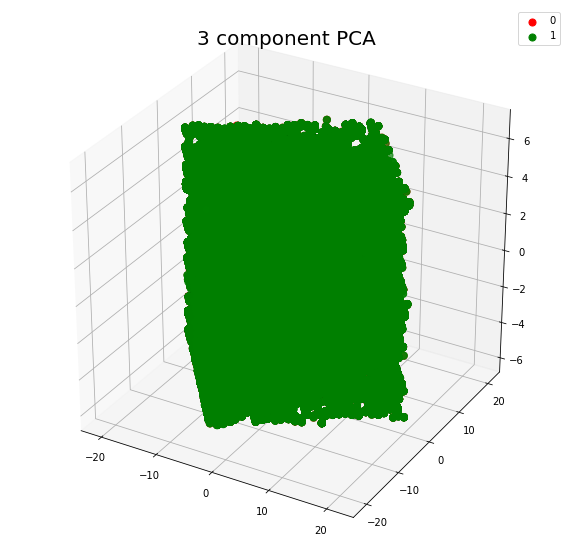

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
#ax = fig.add_subplot(1,1,1) 
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               ,finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
train_target.value_counts(sort=False)

0    260607
1    578253
Name: target, dtype: int64

In [ ]:
jovian.commit()

In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scikit-optimize

In [ ]:
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn import metrics
from sklearn.svm import LinearSVC
from skopt import BayesSearchCV
import numpy as np

In [ ]:
def Create_SGD_Model(learning_rate,alpha,l1_ratio):
  model = SGDClassifier(loss='perceptron',learning_rate='constant',eta0=learning_rate,alpha=alpha,l1_ratio=l1_ratio)
  model.fit(np.array(train_inputs),np.array(train_target))
  validation_label  =  validation_target.astype(int).tolist()
  validation_label = np.array(validation_label).reshape(-1,1)
  validation_predict = model.predict(np.array(validation_input)).astype(int).tolist()
  validation_predict = np.array(validation_predict).reshape(-1,1)
  score = metrics.accuracy_score(validation_label,validation_predict)
  return score 

In [ ]:
score , model = Create_SGD_Model(alpha=0.555,l1_ratio=0.122,learning_rate=2.958 )

In [ ]:
score

0.31197577664926207

{'target': 0.690052865312662, 'params': {'alpha': 1.865847662825355, 'l1_ratio': 0.878784603509513, 'learning_rate': 2.119798135682911}}

In [ ]:
def Create_linearSVC_Model(C):
  model = LinearSVC(C=C,dual=True)
  model.fit(np.array(train_inputs),np.array(train_target))
  validation_label  =  validation_target.astype(int).tolist()
  validation_label = np.array(validation_label).reshape(-1,1)
  validation_predict = model.predict(np.array(validation_input)).astype(int).tolist()
  validation_predict = np.array(validation_predict).reshape(-1,1)
  score = metrics.accuracy_score(validation_label,validation_predict)
  return score , model
#| 8 | 0.6908 | 95.65   

In [ ]:
score_ , model_ = Create_linearSVC_Model(95.65)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
score_

0.6899029635457645

In [ ]:
from bayes_opt import BayesianOptimization
pbounds = {'learning_rate' : (0.00001,10.0),
           'alpha':(0.0,1.0) ,
           'l1_ratio':(0.0,1.0)}
#|  2        |  0.688    |  0.8989   |  0.3954   |  5.302    |           
optimizer = BayesianOptimization(f=Create_SGD_Model,pbounds=pbounds,verbose=100)
optimizer.maximize(init_points=100, n_iter=100)
print(optimizer.max)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/MusicRecommendation/MusicRemmlinearSVC.sav'
pickle.dump(model_, open(filename, 'wb'))

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/ahmedalshoki/musicrecommendationjovian


'https://jovian.ai/ahmedalshoki/musicrecommendationjovian'